In [ ]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense,Merge, RepeatVector, Activation, Flatten,GRU
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

In [ ]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding="utf8")
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = "../../Desktop/main caption file/caption/caption.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1.jpg   গ্রামে হাঁটা দুই শিশু।
1.jpg   দুই শিশু গ্রামে হাঁটছে।
1.jpg   একটা নীল জামা পড়া শিশু।
1.jpg   দুই শিশু খেলা করে।
1.jpg   দুইটা শিশু দাঁড়িয়ে আছে।
2.jpg   কিছু লোক নদী পার করছে।
2.jpg   কিছু লোক বিল পার করছে।
2.jpg   অনেকগুলো লোক নদী পার করছে।
2.jpg   জমির ভিতর অনেকগুলো লোক।
2.jpg   কিছু লোক 


## Creating a dictionary containing all the captions of the images

In [ ]:
        def load_descriptions(doc):
            mapping = dict()
            # process lines
            for line in doc.split('\n'):
                # split line by white space
                tokens = line.split()
                #print(tokens)
                if len(line) < 2:
                    continue
                # take the first token as the image id, the rest as the description
                image_id, image_desc = tokens[0], tokens[1:]
                # extract filename from image id
                image_id = image_id.split('#')[0]
                # convert description tokens back to string
                image_desc=' '.join(image_desc)
                #image_desc= image_desc.split('#',1)[1]
                # create the list if needed
                if image_id not in mapping:
                    mapping[image_id] = list()
                # store description
                mapping[image_id].append(image_desc)
            return mapping

        # parse descriptions
        d = load_descriptions(doc)
        print(d)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    print(row)
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]
print(d)

In [ ]:
d['1.jpg']

['গ্রামে হাঁটা দুই শিশু।',
 'দুই শিশু গ্রামে হাঁটছে।',
 'একটা নীল জামা পড়া শিশু।',
 'দুই শিশু খেলা করে।',
 'দুইটা শিশু দাঁড়িয়ে আছে।']

In [ ]:
images = '../../Desktop/main caption file/'

In [ ]:
# Contains all the images
img = glob.glob(images+'*.jpg')
print(len(img))

8000


In [ ]:
img[:5]

['../../Desktop/main caption file\\1.jpg',
 '../../Desktop/main caption file\\10.jpg',
 '../../Desktop/main caption file\\100.jpg',
 '../../Desktop/main caption file\\1000.jpg',
 '../../Desktop/main caption file\\1001.jpg']

In [ ]:
train_images_file = '../../Desktop/main caption file/caption/train.txt'

In [ ]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [ ]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [ ]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [ ]:
val_images_file = '../../Desktop/main caption file/caption/validation.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [ ]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [ ]:
test_images_file = '../../Desktop/main caption file/caption/test.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [ ]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

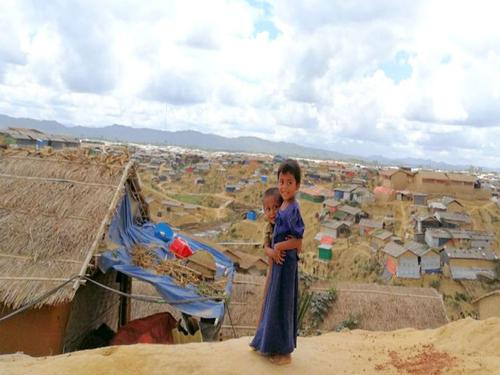

In [ ]:
Image.open(train_img[0])

In [ ]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


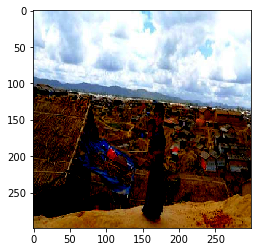

In [ ]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [ ]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [ ]:
tryi = model_new.predict(preprocess(train_img[0]))

In [ ]:
tryi.shape

In [ ]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [ ]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

In [ ]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [ ]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [ ]:
encoding_train['1.jpg'].shape

In [ ]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

In [ ]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [ ]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [ ]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [ ]:
print(images)

../../Desktop/main caption file/


In [ ]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [ ]:
len(train_d)

6000

In [ ]:
#train_d[images+'1001.png']

In [ ]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [ ]:
len(val_d)

1000

In [ ]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [ ]:
len(test_d)

1000

Calculating the unique words in the vocabulary.

In [ ]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [ ]:
words = [i.split() for i in caps]

In [ ]:
unique = []
for i in words:
    unique.extend(i)

In [ ]:
unique = list(set(unique))
print(unique)

['ক্ষেত্রে', 'দাইয়ে', 'দিনমজুর', 'জনবসতি।', 'দেখলে', 'সময়ে', 'গতিতে', 'চাই', 'একজন', 'ভাঙা', 'বাচতে', 'গোশলখানা', 'যাতে', 'ব্রেঞ্চে', 'কান্না', 'ব্ল্যাকবোর্ডে', 'পরিধান', 'পাথর', 'দেখাচ্ছে', 'বিনুনি', 'ঘেরা।', 'হুডির', 'অটোরিকশা', 'বান্ডিল', 'সামনেট', 'গাড়িটিতে', 'ফুটন্ত', 'অাত্নপ্রকাশ', 'রংবেরঙ', 'ব্যানে', 'গাঁটছড়া', 'তীরে।', 'বিভক্ত।', 'একাংশ', 'টাই,', 'আছে,পেছনে', 'লাইটইং', 'কুলায়', 'এর', 'ঔষধের', 'সাফল্যের', 'পপ্রা', 'গার্মেন্টসে', 'দাদার', 'সেবা', 'স্যানিটারির', 'নামাজ', 'চরুই', 'ভোরে', 'বাটি,', 'কাঁদাযু্ক্ত', 'ফোকলা', 'শিশুটিকে', 'ঘাশফুলে', 'হয়ে।', 'ঝুরিলে', 'বালক', 'চিত', 'বাজারজাতকরনে', 'করা।', 'একজনবাচ্চা', 'দেখানো', 'দরজা।', 'বৃহৎ', 'অলোর', 'গাছপালায়', 'নেনেছে', 'png', 'রঙবেরঙ', 'জাফলং।', 'ঘষছে', 'জানালর', 'বাঁধছে।', 'রোগীকে', 'ভর্তি', 'বিচ্ছিন্ন', 'হঠাৎ', 'জনালায়', 'সাফল্য', 'একজোড়া', 'সর্গীয়', 'কপি', 'মারাইয়ের', 'টাকা।', 'টাং', 'প্নির', 'মধ্যের', 'আঁশ', 'কতক', 'তৈজসপাত্র', 'ভলিবল', 'গোলাপি,', 'ওরা', 'আরোহী।', 'আকশে', 'মুহূর্ত।', 'ঘনিয়ে', 'বালিশে', 'সানন্দে', 'প্রারথনা', 

In [ ]:
 with open("unique.p", "wb") as pickle_d:
     pickle.dump(unique, pickle_d) 

In [ ]:
unique = pickle.load(open('unique.p', 'rb'))

In [ ]:
len(unique)

9568

Mapping the unique words to indices and vice-versa

In [ ]:
word2idx = {val:index for index, val in enumerate(unique)}

In [ ]:
word2idx['<start>']

1965

In [ ]:
idx2word = {index:val for index, val in enumerate(unique)}

In [ ]:
idx2word[705]

'যুবকগুলোর'

Calculating the maximum length among all the captions

In [ ]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

41

In [ ]:
len(unique), max_len

(9568, 41)

In [ ]:
vocab_size = len(unique)

In [ ]:
vocab_size

9568

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [ ]:
f = open('flickr8k_training_dataset.txt', 'w',encoding="utf8")
f.write("image_id\tcaptions\n")

18

In [ ]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [ ]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [ ]:
len(df)

29309

In [ ]:
c = [i for i in df['captions']]
len(c)

29309

In [ ]:
imgs = [i for i in df['image_id']]

In [ ]:
a = c[-1]
a, imgs[-1]
print(a.split())

['<start>', 'বৃষ্টি', 'পরছে,', 'এক্টি', 'শিশু', 'কাপড়', 'গায়ে', 'পেচিয়ে', 'পানিতে', 'দাড়িয়ে', 'আছে।', '<end>']


In [ ]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 1965
বৃষ্টি => 3702
পরছে, => 442
এক্টি => 3261
শিশু => 3495
কাপড় => 3151
গায়ে => 1872
পেচিয়ে => 8741
পানিতে => 1495
দাড়িয়ে => 8880
আছে। => 4924
<end> => 7821


In [ ]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [ ]:
samples_per_epoch

258789

In [ ]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [ ]:
embedding_size = 300

In [ ]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [ ]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        GRU(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
final_model = Sequential([
        #Concatenate()([image_model, caption_model],mode='concat', concat_axis=1),
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(GRU(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [ ]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 41, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 41, 300)       2870400                                      
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 41, 256)       427776                                       
___________________________________________________________________________________________

In [ ]:
history=final_model.fit_generator(data_generator(batch_size=512), samples_per_epoch=samples_per_epoch, nb_epoch=100, 
                          verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100


c:\miniconda\envs\thesis\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


273s - loss: 4.7348 - acc: 0.2333
Epoch 2/100
266s - loss: 3.7680 - acc: 0.3337
Epoch 3/100
267s - loss: 3.3820 - acc: 0.3787
Epoch 4/100
269s - loss: 3.1096 - acc: 0.4141
Epoch 5/100
268s - loss: 2.9011 - acc: 0.4432
Epoch 6/100
270s - loss: 2.7318 - acc: 0.4699
Epoch 7/100
269s - loss: 2.5913 - acc: 0.4923
Epoch 8/100
270s - loss: 2.4708 - acc: 0.5115
Epoch 9/100
269s - loss: 2.3658 - acc: 0.5293
Epoch 10/100
268s - loss: 2.2705 - acc: 0.5441
Epoch 11/100
269s - loss: 2.1901 - acc: 0.5589
Epoch 12/100
269s - loss: 2.1159 - acc: 0.5725
Epoch 13/100
269s - loss: 2.0509 - acc: 0.5848
Epoch 14/100
270s - loss: 1.9960 - acc: 0.5949
Epoch 15/100
270s - loss: 1.9505 - acc: 0.6052
Epoch 16/100
269s - loss: 1.9077 - acc: 0.6146
Epoch 17/100
272s - loss: 1.8674 - acc: 0.6240
Epoch 18/100
268s - loss: 1.8346 - acc: 0.6315
Epoch 19/100
268s - loss: 1.8000 - acc: 0.6380
Epoch 20/100
270s - loss: 1.7671 - acc: 0.6465
Epoch 21/100
271s - loss: 1.7333 - acc: 0.6527
Epoch 22/100
272s - loss: 1.7034 -

In [ ]:
final_model.save_weights('time_inceptionV3_3.1_loss.h5')

In [ ]:
final_model.load_weights('time_inceptionV3_3.1_loss.h5')

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=20, 
                          verbose=2)

final_model.save_weights('time_inceptionV3_3.30_loss.h5')

final_model.load_weights('time_inceptionV3_3.30_loss.h5')

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=20, 
                          verbose=2)

final_model.save_weights('time_inceptionV3_3.31_loss.h5')

final_model.load_weights('time_inceptionV3_3.31_loss.h5')

final_model.fit_generator(data_generator(batch_size=512), samples_per_epoch=samples_per_epoch, nb_epoch=20, 
                          verbose=2)

final_model.fit_generator(data_generator(batch_size=512), samples_per_epoch=samples_per_epoch, nb_epoch=20, 
                          verbose=2)

final_model.save_weights('time_inceptionV3_3.32_loss.h5')

final_model.load_weights('time_inceptionV3_3.32_loss.h5')

final_model.fit_generator(data_generator(batch_size=512), samples_per_epoch=samples_per_epoch, nb_epoch=50, 
                          verbose=2)

final_model.save_weights('time_inceptionV3_3.32_loss.h5')

final_model.load_weights('time_inceptionV3_3.32_loss.h5')

## Predict funtion

In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

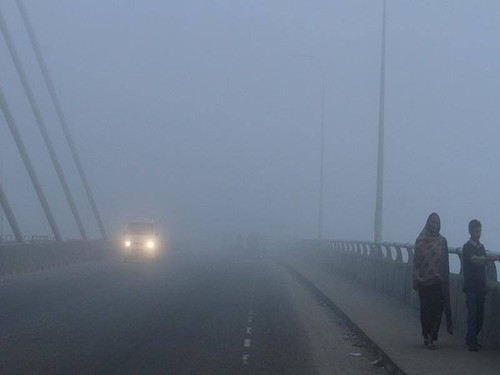

In [ ]:
try_image = test_img[300]
Image.open(try_image)

In [ ]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: রাস্তার দুপাশে মানুষ আর মানুষ হাঁটছে।
Beam Search, k=3: দুজন মানুষ হেঁটে যাচ্ছে।
Beam Search, k=5: দুজন মানুষ হেঁটে যাচ্ছে।
Beam Search, k=7: দুজন মানুষ হেঁটে যাচ্ছে।


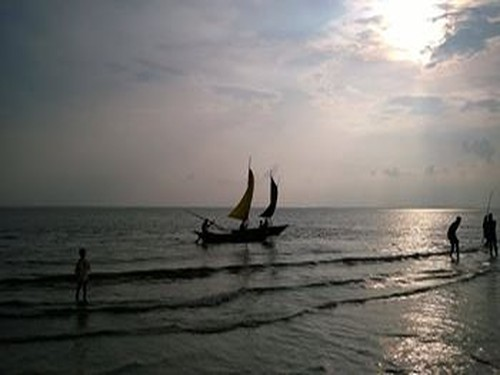

In [ ]:
try_image2 = test_img[78]
Image.open(try_image2)

In [ ]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: কয়েকজন মানুষ সমুদ্র পাড়ে এবং একটি পাল তোলা নৌকা যাচ্ছে
Beam Search, k=3: কয়েকজন মানুষ সমুদ্র পাড়ে এবং একটি পাল তোলা নৌকা যাচ্ছে।
Beam Search, k=5: সমুদ্রের পারে কয়েকজন মানুষ আছে।
Beam Search, k=7: সমুদ্রের পারে কয়েকজন মানুষ আছে।


In [ ]:
for i in range(10,20):
    try_image3 = test_img[4]

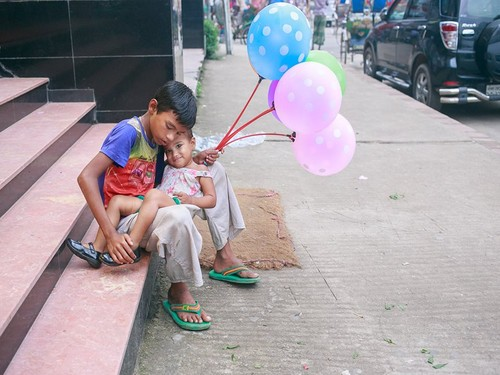

In [ ]:
try_image3 = test_img[365]
Image.open(try_image3)

In [ ]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: একজন ছেলে ও একজন মেয়ে হাতে দুইটি পতাকা নিয়ে যাচ্ছে
Beam Search, k=3: একজন পুরুষ হাতে পতাকা নিয়ে আছে।
Beam Search, k=5: একজন পুরুষ হাতে পতাকা নিয়ে বসে আছে।
Beam Search, k=7: একজন পুরুষ হাতে পতাকা নিয়ে রাস্তা থেকে হেটে যাচ্ছে ।


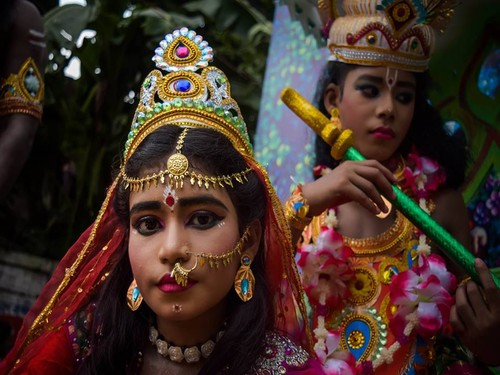

In [ ]:
    try_image3 = test_img[48]
    Image.open(try_image3)

In [ ]:

    print ('Normal Max search:', predict_captions(try_image3)) 
    print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
    print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
    print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))
    

Normal Max search: ২ জন মেয়ে সেজে একটি সেজে সেজে সেজে সেজে সেজে দাড়িয়ে আছেন।
Beam Search, k=3: ২ জন ছোট মেয়ে সেজে হাতে একটি দুই হাত তুলে আছেন।
Beam Search, k=5: ২ জন ছোট মেয়ে সেজে হাতে একটি দুই হাত তুলে আছেন।
Beam Search, k=7: দুই জন মেয়ে সেজে হাসছে


In [ ]:
image = test_img[0]
    #image = encoding_test[x].reshape((1,4096))
yhat = beam_search_predictions(image, beam_index=7)

In [ ]:
print(yhat.split())

['একজন', 'পুরুষ', 'হেঁটে', 'আসছে।']


In [ ]:
actual, predicted = list(), list()
for x in tqdm(range(0,1000)):
    image = test_img[x]
    #image = encoding_test[x].reshape((1,4096))
    yhat = predict_captions(image)
        # store actual and predicted
    y=yhat.split()
    z=image.split('\\')
    z=z[-1]
    references=[x.split() for x in d[z]]
    actual.append(references)
    predicted.append(y)
    # calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:41<00:00,  2.49it/s]


BLEU-1: 0.383640
BLEU-2: 0.230477
BLEU-3: 0.182198
BLEU-4: 0.113474


In [ ]:
import nltk
nltk.download('wordnet')
b=0.0
for x in tqdm(range(0,1000)):
    a=[]
    image = test_img[x]
    #image = encoding_test[x].reshape((1,4096))
    yhat = predict_captions(image)
        # store actual and predicted
    z=image.split('\\')
    z=z[-1]
    for x in d[z]:
        a.append(x)
    b+=round(meteor_score(a, yhat),4)
print(b/1000)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hilton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:43<00:00,  2.48it/s]

0.26555919999999983


In [ ]:
print("Meteor Score:"+(str((b/1000)*100)))

Meteor Score:26.555919999999983


In [ ]:
acc=[]
for x in history.history['acc']:
    acc.append(x*100)

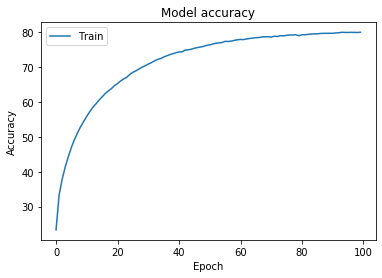

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
loss=[]
for x in history.history['loss']:
    loss.append(x*10)

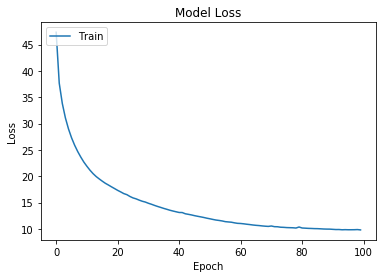

In [ ]:
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
actual, predicted = list(), list()
BLEU_1,BLEU_2,BLEU_3,BLEU_4=0.0,0.0,0.0,0.0
for x in tqdm(range(0,1000)):
    image = test_img[x]
    #image = encoding_test[x].reshape((1,4096))
    yhat = predict_captions(image)
        # store actual and predicted
    y=yhat.split()
    z=image.split('\\')
    z=z[-1]
    references=[x.split() for x in d[z]]
    actual.append(references)
    predicted.append(y)
    # calculate BLEU score
BLEU_1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
BLEU_2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
BLEU_3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
BLEU_4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:41<00:00,  2.49it/s]


In [ ]:

BLEU_1=BLEU_1*100
BLEU_2=BLEU_2*100
BLEU_3=BLEU_3*100
BLEU_4=BLEU_4*100
print('BLEU-1: %f'% BLEU_1)
print('BLEU-2: %f'% BLEU_2)
print('BLEU-3: %f'% BLEU_3)
print('BLEU-4: %f'% BLEU_4)

BLEU-1: 38.364038
BLEU-2: 23.047654
BLEU-3: 18.219840
BLEU-4: 11.347365


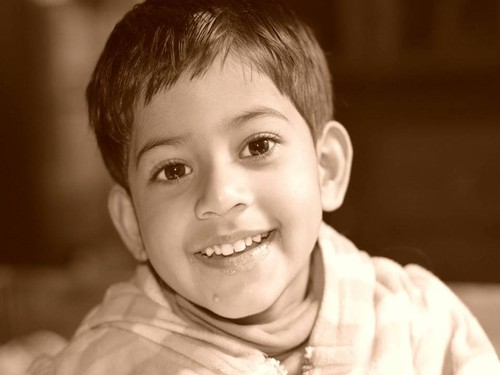

In [ ]:
try_image3 = test_img[60]
Image.open(try_image3)

In [ ]:

    print ('Normal Max search:', predict_captions(try_image3)) 
    print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
    print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
    print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: একটি শিশু তাকিয়ে আছে
Beam Search, k=3: একটি শিশু তাকিয়ে আছে
Beam Search, k=5: একটি শিশু তাকিয়ে আছে
Beam Search, k=7: একটি শিশু তাকিয়ে আছে


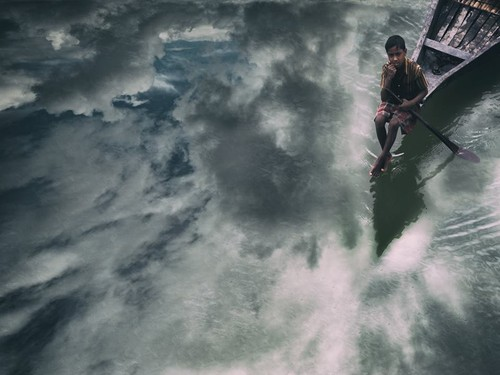

In [ ]:
try_image3 = test_img[88]
Image.open(try_image3)

In [ ]:
    print ('Normal Max search:', predict_captions(try_image3)) 
    print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
    print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
    print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: নৌকার ডগায় একজন ছোট ছেলে বৈঠা হাতে বসে আছেন।
Beam Search, k=3: নৌকার ডগায় একজন ছোট ছেলে বৈঠা হাতে বসে আছে এবং পানিতে আকাশের প্রতিচ্ছবি দেখা যাচ্ছে।
Beam Search, k=5: নৌকার ডগায় একজন ছোট ছেলে বৈঠা হাতে বসে আছে এবং পানিতে আকাশের প্রতিচ্ছবি দেখা যাচ্ছে।
Beam Search, k=7: নৌকার ডগায় একজন ছোট ছেলে বৈঠা হাতে বসে আছে এবং পানিতে আকাশের প্রতিচ্ছবি দেখা যাচ্ছে।
